# Evaluating LSTM on Sports dataset

In [1]:
# based on: https://www.kaggle.com/mlwhiz/multiclass-text-classification-pytorch/notebook
# necessary modules
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
embed_size = 300 # how big is each word vector
n_layers = 1
hidden_size = 128
fcl_size = 64
max_features = 200000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 60 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 10 # how many times to iterate over all samples

## 1. Loading evaluation dataset

In [3]:
# Loading the evaluation data
df_eval = pd.read_pickle("data/Sports_and_Outdoors_5_balanced_with_stopwords.pkl")

In [4]:
df_eval

,reviewText,overall,label
0,"[bike, commute, couple, of, days, each, week, ...",5.0,2.0
1,"[have, been, rolling, for, years, now, and, fa...",5.0,2.0
2,"[this, is, one, cool, knife, have, lot, of, kn...",5.0,2.0
3,"[easier, to, put, together, than, my, last, tr...",4.0,2.0
4,"[excellent, value, and, product, this, rain, f...",5.0,2.0
...,...,...,...
1022932,"[nbsp, diameter, basic, specs, only, have, rid...",2.0,0.0
1022933,"[way, too, big, to, be, practical]",2.0,0.0
1022934,[novelty],1.0,0.0
1022935,"[bought, this, for, my, son, he, used, it, ton...",2.0,0.0


In [5]:
test_X = list(df_eval['reviewText'])
test_y = df_eval['label'].values

## 2. Loading pre-trained LSTM and tokenizer

In [7]:
import pickle

# loading tokenizer used during training LSTM model
with open('data/tokenizer_with_stoppwords.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [8]:
# Converting text to sequence of numbers
test_X = tokenizer.texts_to_sequences(list(test_X))

## Pad the sentences 
test_X = pad_sequences(test_X, maxlen=maxlen)

In [9]:
test_X

array([[    5,  1515,   723, ...,  2447,    49, 15869],
       [    0,     0,     0, ...,  1242,  1844,  3552],
       [    9,   380,    12, ...,   183,     8,   184],
       ...,
       [    0,     0,     0, ...,     0,     0,  7666],
       [  378,   564,   361, ...,     7,     8,  3910],
       [10584,     1, 41988, ...,     1,  2679,  9655]])

In [10]:
class LSTM(nn.Module):
    
    def __init__(self):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        drp = 0.2
        n_classes = 3
        self.embedding = nn.Embedding(max_features, embed_size)
        self.lstm = nn.LSTM(embed_size, self.hidden_size, num_layers = n_layers, batch_first=True)
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(self.hidden_size, n_classes)


    def forward(self, x):
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        
        # conc = self.relu(self.linear(h_lstm[:,-1,:]))
        conc = h_lstm[:,-1,:]
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [11]:
model = LSTM()

In [12]:
# Loading pre-trained model for evaluation
model.load_state_dict(torch.load("lstm_glove200k_10epoch_with_stoppwords"))
model.cuda()

LSTM(
  (embedding): Embedding(200000, 300)
  (lstm): LSTM(300, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=128, out_features=3, bias=True)
)

## 3. Creating evaluation data loader

In [13]:
# Load train and test in CUDA Memory
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

In [14]:
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

In [15]:
val_preds = np.zeros((len(x_cv),3))
model.eval()  
for i, (x_batch, y_batch) in enumerate(valid_loader):
    y_pred = model(x_batch).detach()
    # keep/store predictions
    val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred, dim = 1).cpu().numpy()
    
# Check Accuracy
val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)

In [16]:
val_accuracy

0.6979647817998567

## 4. Confusion matrix

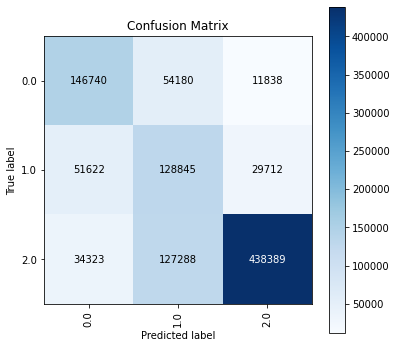

In [18]:
import scikitplot as skplt
y_true = [x for x in test_y]
y_pred = [x for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(6,6),x_tick_rotation=90)
plt.savefig("conf_matrix_eval_withstopwords.png")

## 5. Performance metrics

In [19]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
print('F1: {}'.format(f1_score(y_true, y_pred, average = None)))
print('Precision: {}'.format(precision_score(y_true, y_pred, average = None)))
print('Recall: {}'.format(recall_score(y_true, y_pred, average = None)))
print(f'AUC: {roc_auc_score(y_true, val_preds, multi_class="ovr")}')

Accuracy: 0.6979647817998567
F1: [0.65884973 0.49508926 0.81187734]
Precision: [0.63063799 0.4152098  0.9134265 ]
Recall: [0.68970379 0.61302509 0.73064833]
AUC: 0.8661601819697881


## 6. Plot AUC curves for each class

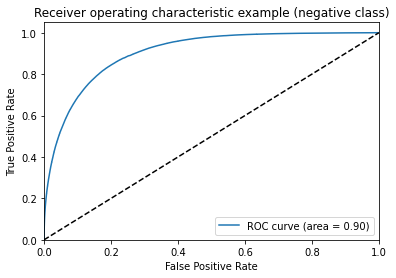

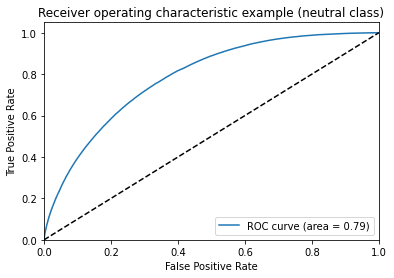

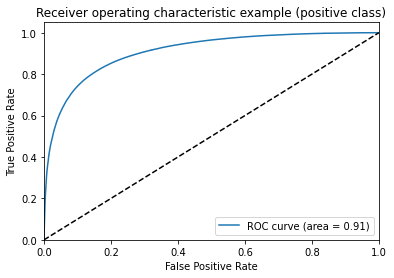

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

# Creating OneHotEncoded labels for multiclasss plots
enc = OneHotEncoder(handle_unknown='ignore')
y_test = np.array(enc.fit_transform(np.array(y_true).reshape(-1, 1)).todense())

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], val_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
classes = ['negative', 'neutral', 'positive']
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic example ({classes[i]} class)')
    plt.legend(loc="lower right")
    plt.savefig(f"eval_auc_curves_with_stopwords_{classes[i]}.png")